#**Análise da mobilidade dos transportes públicos de Natal-RN**

---
Projeto desenvolvido para a disciplina IMD1155 - Análise de Redes, com o intuito de aplicar os conteúdos vistos em sala para solucionar problemas do dia a dia.

O projeto consiste na análise das rotas de ônibus de Natal, RN, utilizando as ruas dos centros urbanos de Natal como arestas e as trajetórias dos ônibus como vértices. Além disso, utilizaremos como peso a quantidade de viagens realizadas e/ou a bilhetagem de cada linha.



Instalação e importação das bibliotecas necessárias:

In [66]:
!pip install networkx

In [67]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

Leitura e atribuição dos dados a uma variável:

In [68]:
data = pd.read_csv('/content/drive/MyDrive/PROJETO_TRANSPORTE_URBANO/itinerario_geral.csv', sep=";")

In [69]:
data.head()

Empresa Linha                       Nome  \
0  VIA SUL    50  SERRAMBI / SANTA CATARINA   
1  VIA SUL    50  SERRAMBI / SANTA CATARINA   
2  VIA SUL    50  SERRAMBI / SANTA CATARINA   
3  VIA SUL    50  SERRAMBI / SANTA CATARINA   
4  VIA SUL    50  SERRAMBI / SANTA CATARINA   

                                  Ida                        Volta  
0      RUA DR. JULIO CESAR (Terminal)     AV BACHAREL TOMAZ LANDIM  
1       RUA JOAQUIM EDUARDO DE FARIAS  AV. FELIZARDO FIRMINO MOURA  
2  RUA ESCRITOR EURICO FARIAS LACERDA                  RUA JANDIRA  
3                  RUA ESTÂNCIA VELHA            VIADUTO DA URBANA  
4                    AV. AYRTON SENNA          AV. BERNARDO VIEIRA

Tinham alguns dados NaN devido a um ônibus se manter na mesma rua e não repetir o nome da mesma, isso foi resolvido com um dos métodos de se lidar com NaNs, que substitui o NaN por um dado anterior:

In [70]:
data = data.fillna(method='ffill')

In [71]:
has_nan = data.isna().any()

print(has_nan)

Empresa    False
Linha      False
Nome       False
Ida        False
Volta      False
dtype: bool


Após isso realizamos a criação do grafo de modo direcionado afim de poder realizar calculos posteriormente:

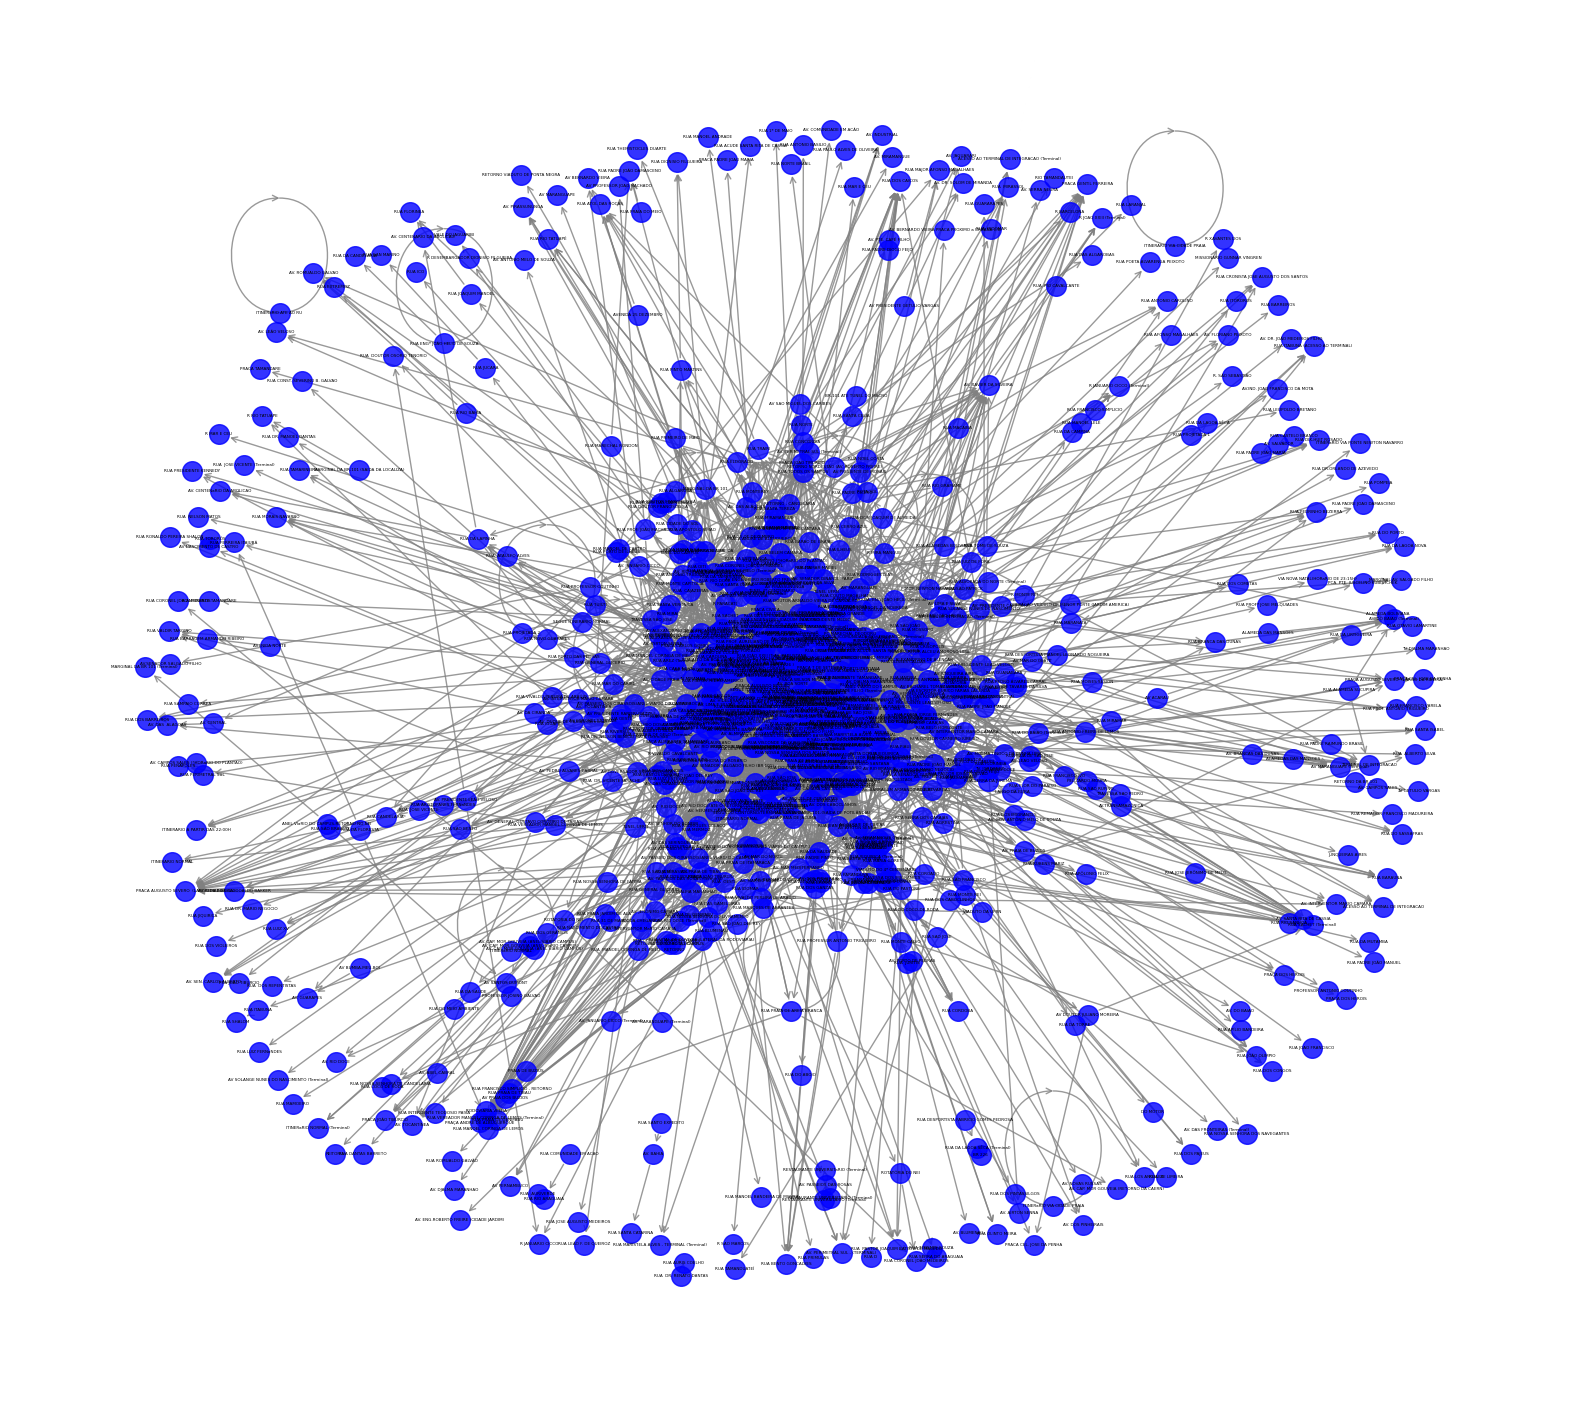

In [72]:
#Criando o grafo direcionado
G = nx.DiGraph()

#Laço para adicionar nós e arestas usando o .loc para armazenar os dados referentes a cada coluna
for i in range(len(data)):
  empresa = data.loc[i, 'Empresa']
  linha = data.loc[i, 'Linha']
  nome = data.loc[i, 'Nome']
  ida = data.loc[i, 'Ida']
  volta = data.loc[i, 'Volta']

  G.add_node(ida)
  G.add_node(volta)
  G.add_edge(ida, volta, linha=linha)

#Obter as posições dos nós
pos = nx.spring_layout(G)

#Criar a figura do gráfico, onde fig e ax são as variaveis que recebem
#o retono da função de subplots
fig, ax = plt.subplots(figsize=(20, 18))

#Desenhar os nós
nx.draw_networkx_nodes(G, pos, ax=ax, node_size=200, node_color='b', alpha=0.8)

#Desenhar as arestas
nx.draw_networkx_edges(G, pos, ax=ax, arrows=True, arrowstyle='->', arrowsize=10, edge_color='gray', alpha=0.8)

#Adicionar rótulos aos nós
nx.draw_networkx_labels(G, pos, font_size=3)

#Remover os eixos
ax.axis('off')

#Exibir o gráfico
plt.show()

###Agora iremos fazer os cálculos conforme a indicação do projeto:

*   Matriz de adjacência.
*   Diâmetro e periferia da rede
*   Esparsidade/Densidade da Rede.
*   Assortatividade geral da rede.
*   Histograma de distribuição empírica de grau.





In [73]:
#Obter a matriz de adjacência
adj_matrix = nx.adjacency_matrix(G).toarray()

#Exibir as 5 primeiras linhas da matriz de adjacência
print(adj_matrix[:5, ])

[[0 1 0 ... 0 0 0]
 [1 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [74]:
fortemente_conectados = list(nx.strongly_connected_components(G))

componentes_sconectados = max(fortemente_conectados, key=len)

subgrafo = G.subgraph(componentes_sconectados)

diametro = nx.diameter(subgrafo)
print("Diâmetro do subgrafo:", diametro)

periferia = nx.periphery(subgrafo)
print("Periferia do subgrafo:", periferia)

Diâmetro do subgrafo: 11
Periferia do subgrafo: ['AV CORONEL ESTEVAM']


Diâmetro e periferia da rede:
*   Foi necessário a criação de um subgrafo pois os elementos não eram fortemente conectados.
*   Após isso foi calculado o diâmetro e periferia que indicaram sinais que no subgrafo a maior distância entre dois 'nós' seria de 11 arestas, além disso o resultado da periferia mostra que a 'AV CORONEL ESTEVAM' está na borda externa mais distante dos demais 'nós'.

In [75]:
esparsidade = nx.density(G)
print("Esparsidade da rede:", esparsidade)

assortatividade = nx.degree_assortativity_coefficient(G)
print("Assortatividade geral da rede:", assortatividade)

Esparsidade da rede: 0.0031731470752328224
Assortatividade geral da rede: -0.06079111205522156


Indice de esparsidade da rede e assortatividade geral da rede:

*   Em relação a esparsidade de rede esse valor indica que é bastante esparsa e possui uma baixa densidade de conexões em relação ao máximo de possibilidades
*   Já a assortatividade negativa indica que os nós com graus diferentes tem maior probilidade de conexão e por estar proximo de 0 parece ser fraca.

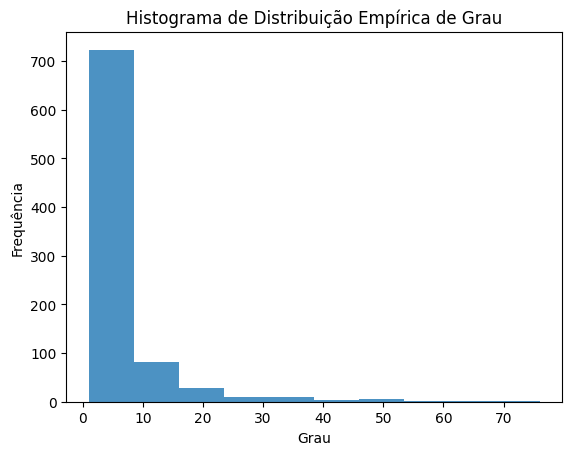

In [76]:
degree_sequence = [degree for node, degree in G.degree()]

plt.hist(degree_sequence, bins=10, alpha=0.8)

plt.xlabel('Grau')
plt.ylabel('Frequência')

plt.title('Histograma de Distribuição Empírica de Grau')

plt.show()

###Continuando com os cálculos solicitados:

*   Coeﬁciente de clustering local para nós escolhidos;
*   Coeﬁciente de clustering global;
*   Componentes Conectados Fortemente;
*   Componentes Conectados Fracamente;

In [77]:
#como "nós" selecionamos ruas e avenidas que consideramos as mais movimentadas
no_selecionado = ['AV. AYRTON SENNA', 'AV. ENGENHEIRO ROBERTO FREIRE', 'AV. BERNARDO VIEIRA', 'RUA DR. MARIO NEGOCIO', 'AV. SENADOR SALGADO FILHO', 'BR 101']

clustering_coeficiente = nx.clustering(G, no_selecionado)
print("Coeficiente de clustering local:")
for node, cc in clustering_coeficiente.items():
    print("Nó:", node, "- Coeficiente de clustering:", cc)

clustering_global = nx.average_clustering(G)
print("Coeficiente de clustering global:", clustering_global)

fortemente_conectados = list(nx.strongly_connected_components(G))
print("Componentes conectados fortemente:", fortemente_conectados)

# Componentes conectados fracamente
fracamente_conectados = list(nx.weakly_connected_components(G))
print("Componentes conectados fracamente:", fracamente_conectados)

Coeficiente de clustering local:
Nó: AV. AYRTON SENNA - Coeficiente de clustering: 0.02197802197802198
Nó: AV. ENGENHEIRO ROBERTO FREIRE - Coeficiente de clustering: 0.027472527472527472
Nó: AV. BERNARDO VIEIRA - Coeficiente de clustering: 0.032
Nó: RUA DR. MARIO NEGOCIO - Coeficiente de clustering: 0.2593984962406015
Nó: AV. SENADOR SALGADO FILHO - Coeficiente de clustering: 0.018026565464895637
Nó: BR 101 - Coeficiente de clustering: 0.015126737530662305
Coeficiente de clustering global: 0.026155849970539144
Componentes conectados fortemente: [{'AV. INTERVENTOR MARIO CAMARA'}, {'PRACA GENTIL FERREIRA'}, {'R JOAO XXIII (Terminal)'}, {'AV. XAVIER DA SILVEIRA'}, {'RUA DR.ORLANDO DE AZEVEDO'}, {'RUA VEREADOR MANOEL CORINGA DE LEMOS (Terminal)', 'RODOVIARIA VELHA'}, {'RUA DIONISIO FILGUEIRA'}, {'R DESEMBARGADOR DIONISIO FILGUEIRA'}, {'RUA MARISTELA ALVES - TERMINAL (Terminal)'}, {'RUA MAJOR AFONSO MAGALHAES'}, {'PRACA TAMANDARE'}, {'RUA ANTONIO CAROLINO'}, {'PRAÇA CEL. JOSE DA PENHA'}, {'

Analisando os resultados de clustering local, nós podemos perceber que os "nós" selecionados tem um coeficiente muito baixo, o que pode significar um certo isolamento em relação aos outros "nós", isso pode ter uma explicação já que como são avenidas maiores e com mais paradas, os transportes tendem percorrer elas de forma integral e não ter contato com outras ruas menores ao redor.

Já em relação ao global vemos que o resultado teve uma média parecida com as locais selecionadas, assim indica que os nós na rede têm uma tendência geralmente baixa de estarem conectados em agrupamentos densos e por fim exibimos a lista de componentes fortemente conectados e fracamente.

###**Visualizações**

O objetivo é exibir os nós mais importantes do nosso grafo e fazer comparações de:

*   Eigenvector centrality;
*   Degree centrality;
*   Closeness centrality;
*   Betweenness centrality.



Primeiramente vamos calcular e exibir o nós mais importantes:

In [78]:
#Calcular as medidas de centralidade
eigenvector_centrality = nx.eigenvector_centrality(G)
degree_centrality = nx.degree_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)

#Ordenar os nós mais importantes para cada medida de centralidade
nos_mais_importantes_eigenvector = sorted(eigenvector_centrality, key=eigenvector_centrality.get, reverse=True)
nos_mais_importantes_degree = sorted(degree_centrality, key=degree_centrality.get, reverse=True)
nos_mais_importantes_closeness = sorted(closeness_centrality, key=closeness_centrality.get, reverse=True)
nos_mais_importantes_betweenness = sorted(betweenness_centrality, key=betweenness_centrality.get, reverse=True)

#Exibir os nós mais importantes para cada medida de centralidade
print("Nós mais importantes pelo Eigenvector centrality:")
for no in nos_mais_importantes_eigenvector[:5]:
    print(no)

print("\nNós mais importantes pelo Degree centrality:")
for no in nos_mais_importantes_degree[:5]:
    print(no)

print("\nNós mais importantes pelo Closeness centrality:")
for no in nos_mais_importantes_closeness[:5]:
    print(no)

print("\nNós mais importantes pelo Betweenness centrality:")
for no in nos_mais_importantes_betweenness[:5]:
    print(no)

Nós mais importantes pelo Eigenvector centrality:
AV BACHAREL TOMAZ LANDIM
AV. FELIZARDO FIRMINO MOURA
AV. DR. JOAO MEDEIROS FILHO
RUA VEREADOR MANOEL CORINGA DE LEMOS (Terminal)
RUA AMARO BARRETO

Nós mais importantes pelo Degree centrality:
AV. DUQUE DE CAXIAS
AV. PRUDENTE DE MORAIS
AV. DR. JOAO MEDEIROS FILHO
RUA CORONEL JOSE BERNARDO
AV BACHAREL TOMAZ LANDIM

Nós mais importantes pelo Closeness centrality:
RUA VEREADOR MANOEL CORINGA DE LEMOS (Terminal)
AV BACHAREL TOMAZ LANDIM
RUA AMARO BARRETO
AV. DR. JOAO MEDEIROS FILHO
RUA PADRE PINTO

Nós mais importantes pelo Betweenness centrality:
AV. DUQUE DE CAXIAS
RUA CORONEL JOSE BERNARDO
AV. CAPITAO-MOR GOUVEIA
BR 101
AV. DR. JOAO MEDEIROS FILHO


A partir dos resultados já podemos ver que temos :

---

* Na lista dos nós mais importantes pelo Eigenvector centrality, "AV BACHAREL TOMAZ LANDIM" e "AV. DR. JOAO MEDEIROS FILHO". Isso pode indicar que esses nós possuem conexões com outros nós que são considerados importantes dentro da rede.

* Da mesma forma, na lista dos nós mais importantes pelo Degree centrality, temos "AV. DR. JOAO MEDEIROS FILHO" e "AV BACHAREL TOMAZ LANDIM". Isso sugere que esses nós têm um alto número de conexões com outros nós na rede, isso nos diz que na região norte da cidade temos mais nós do que nas outras regiões.

* No caso da lista dos nós mais importantes pelo Closeness centrality, novamente encontramos "AV BACHAREL TOMAZ LANDIM" e "AV. DR. JOAO MEDEIROS FILHO". Isso pode indicar que esses nós estão localizados em posições mais centrais e próximas a outros nós na rede, e como citado anteriormente isso reforça que temos uma centralização dos nós nessa região especifica da cidade.

* Por fim, na lista dos nós mais importantes pelo Betweenness centrality, temos "AV. DUQUE DE CAXIAS", "RUA CORONEL JOSE BERNARDO" e "AV. DR. JOAO MEDEIROS FILHO". Isso sugere que esses nós desempenham um papel importante na intermediação de caminhos curtos entre outros nós na rede, mais uma vez vemos a "AV. DR. JOAO MEDEIROS FILHO" o que também nos indica que a maioria das trajetorias da região passa por essa avenida na região norte.

Infelizmente não conseguimos importar os graficos conforme o link de exemplo, o máximo que conseguimos com as limitações do projeto foram os gráficos abaixo:

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


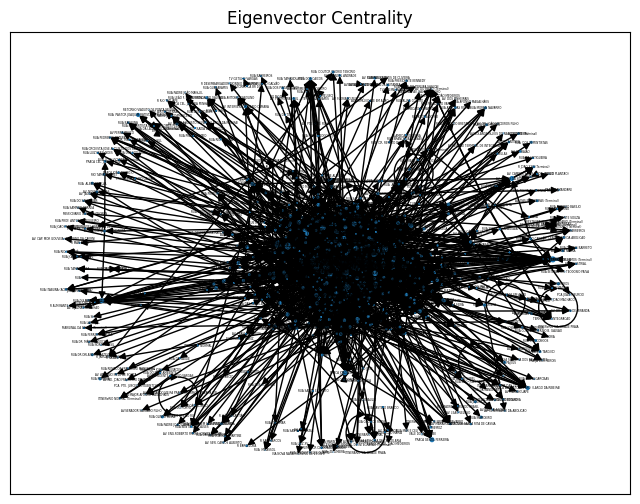

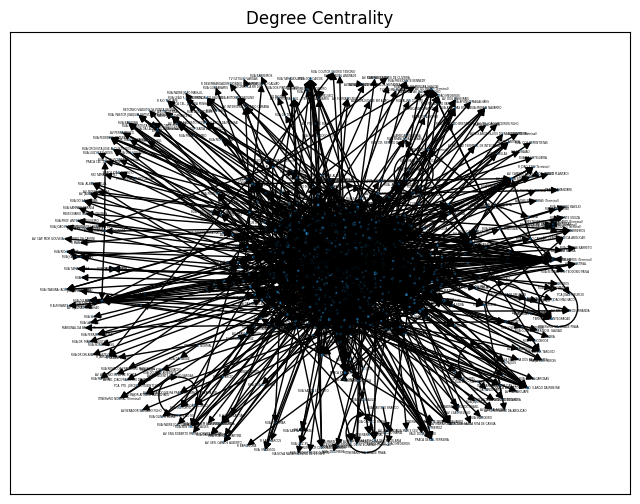

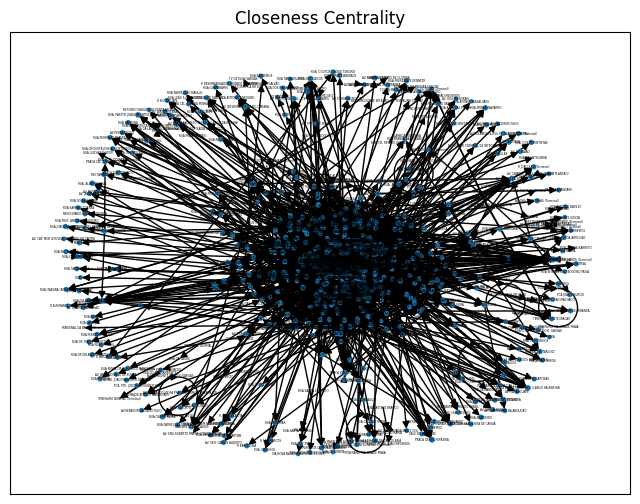

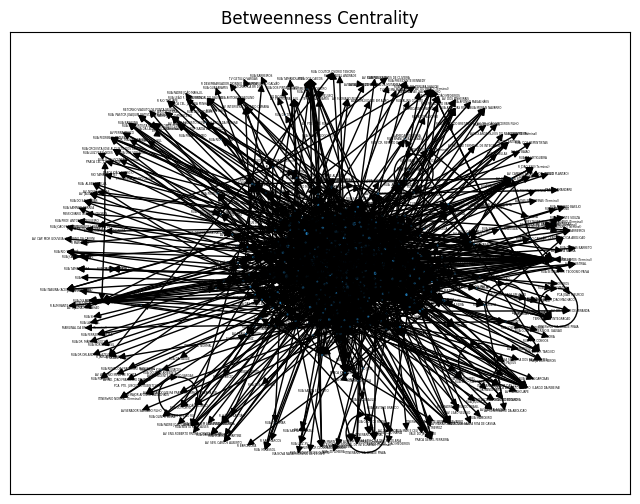

In [79]:
# Calculando as medidas de centralidade
eigenvector_centrality = nx.eigenvector_centrality(G)
degree_centrality = nx.degree_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)

# Definindo o tamanho dos nós com base nas medidas de centralidade
node_size_eigenvector = [50 * eigenvector_centrality[node] for node in G.nodes()]
node_size_degree = [50 * degree_centrality[node] for node in G.nodes()]
node_size_closeness = [50 * closeness_centrality[node] for node in G.nodes()]
node_size_betweenness = [50 * betweenness_centrality[node] for node in G.nodes()]

# Plotando o grafo com as medidas de centralidade
pos = nx.spring_layout(G)  # Define o layout do grafo

# Plotando o grafo com eigenvector centrality
plt.figure(figsize=(8, 6))
nx.draw_networkx(G, pos, node_size=node_size_eigenvector, cmap=plt.cm.Blues, with_labels=True, font_size=2)
plt.title("Eigenvector Centrality")
plt.show()

# Plotando o grafo com degree centrality
plt.figure(figsize=(8, 6))
nx.draw_networkx(G, pos, node_size=node_size_degree, cmap=plt.cm.Blues, with_labels=True, font_size=2)
plt.title("Degree Centrality")
plt.show()

# Plotando o grafo com closeness centrality
plt.figure(figsize=(8, 6))
nx.draw_networkx(G, pos, node_size=node_size_closeness, cmap=plt.cm.Blues, with_labels=True, font_size=2)
plt.title("Closeness Centrality")
plt.show()

# Plotando o grafo com betweenness centrality
plt.figure(figsize=(8, 6))
nx.draw_networkx(G, pos, node_size=node_size_betweenness, cmap=plt.cm.Blues, with_labels=True, font_size=2)
plt.title("Betweenness Centrality")
plt.show()


###Detecção de Comunidades

Após realizar varias tentativas sem sucesso, a unica versão que conseguimos de detecção de comunidades foi essa que ficou imperfeita

In [80]:
!pip install python-igraph louvain

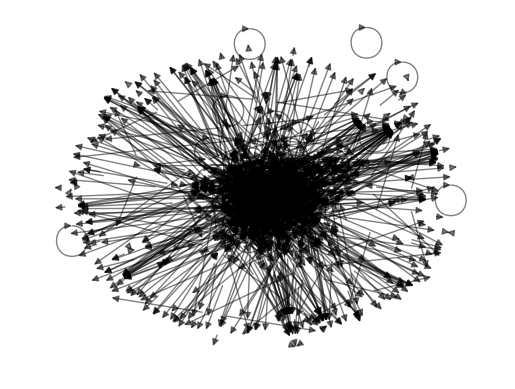

In [81]:
import networkx as nx
import matplotlib.pyplot as plt
import igraph as ig
import louvain


# Converter o grafo do networkx para o formato do igraph
data_igraph = ig.Graph.TupleList(G.edges(), directed=False)

# Executar a detecção de comunidades usando o algoritmo Louvain
partitions = louvain.find_partition(data_igraph, louvain.ModularityVertexPartition)

# Obter a lista de comunidades únicas
unique_communities = set(partitions.membership)

# Calcular o layout do gráfico
pos = nx.spring_layout(G)

# Verificar se todos os nós estão presentes no layout
missing_nodes = set(G.nodes()) - set(pos.keys())
if missing_nodes:
    # Remover os nós não presentes no layout
    G.remove_nodes_from(missing_nodes)
    partitions = louvain.find_partition(G, louvain.ModularityVertexPartition)
    unique_communities = set(partitions.membership)

# Desenhar os nós
for community_id in unique_communities:
    nodes = [node for node, community in enumerate(partitions.membership) if community == community_id]
    subgraph = G.subgraph(nodes)  # Subgrafo da comunidade
    nx.draw_networkx_nodes(subgraph, pos, node_color='tab20', label=f'Community {community_id}')

# Desenhar as arestas
nx.draw_networkx_edges(G, pos, alpha=0.5)

# Remover os eixos
plt.axis('off')

# Exibir o gráfico
plt.show()

###Outras analises realizadas com os dados:

*   Ruas que mais aparecem como caminho de ida dos veiculos;
*   Ruas que mais aparecem como caminho de volta dos veiculos;
*   Tamanho da frota por empresa;
*   Bilhetagem.






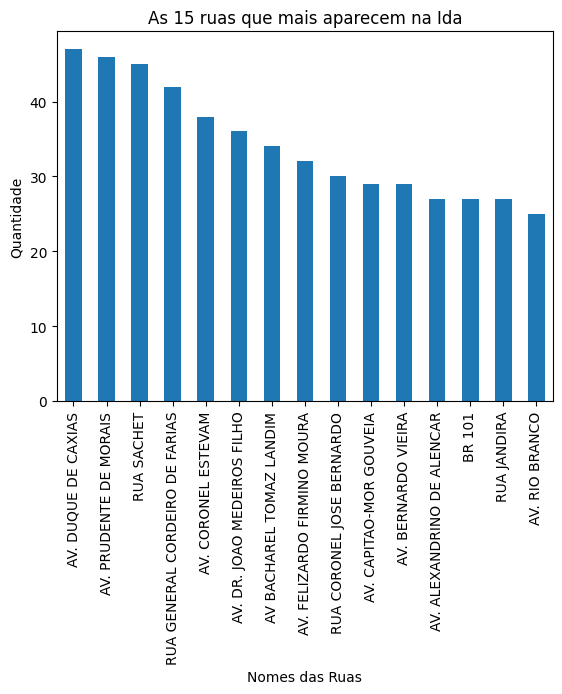

In [82]:
ruas = data['Ida'].value_counts()

valores_comuns = ruas.head(15)

valores_comuns.plot(kind='bar')

plt.xlabel('Nomes das Ruas')
plt.ylabel('Quantidade')
plt.title('As 15 ruas que mais aparecem na Ida')
plt.show()

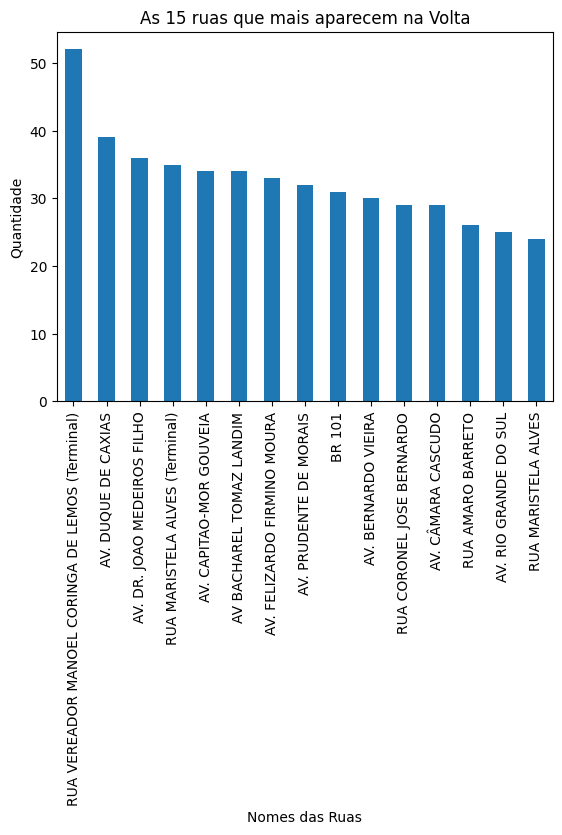

In [83]:
ruas = data['Volta'].value_counts()

valores_comuns = ruas.head(15)

valores_comuns.plot(kind='bar')

plt.xlabel('Nomes das Ruas')
plt.ylabel('Quantidade')
plt.title('As 15 ruas que mais aparecem na Volta')

# Exibir o gráfico
plt.show()

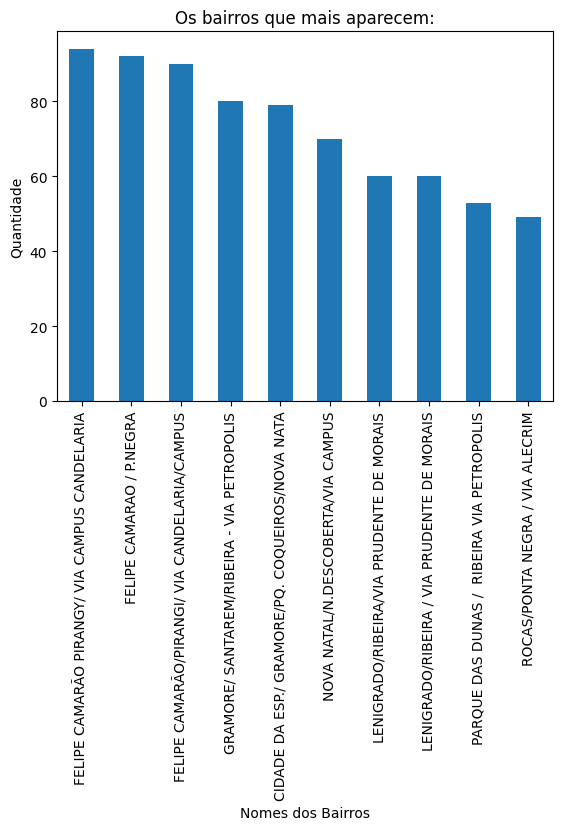

In [84]:
bairros = data['Nome'].value_counts()

valores_bairros = bairros.head(10)

valores_bairros.plot(kind='bar')

plt.xlabel('Nomes dos Bairros')
plt.ylabel('Quantidade')
plt.title('Os bairros que mais aparecem:')
plt.show()

In [85]:
analisis = data.drop(['Ida','Volta','Nome'], axis=1)
analisis = analisis.drop_duplicates(subset='Linha')
analisis

Empresa Linha
0             VIA SUL    50
21            VIA SUL   588
28            VIA SUL    51
49            VIA SUL    52
76            VIA SUL    65
...               ...   ...
2614        CONCEICÃO    71
2645  CIDADE DO NATAL   600
2656  CIDADE DO NATAL    33
2759  CIDADE DO NATAL    40
2800  CIDADE DO NATAL    57

[86 rows x 2 columns]

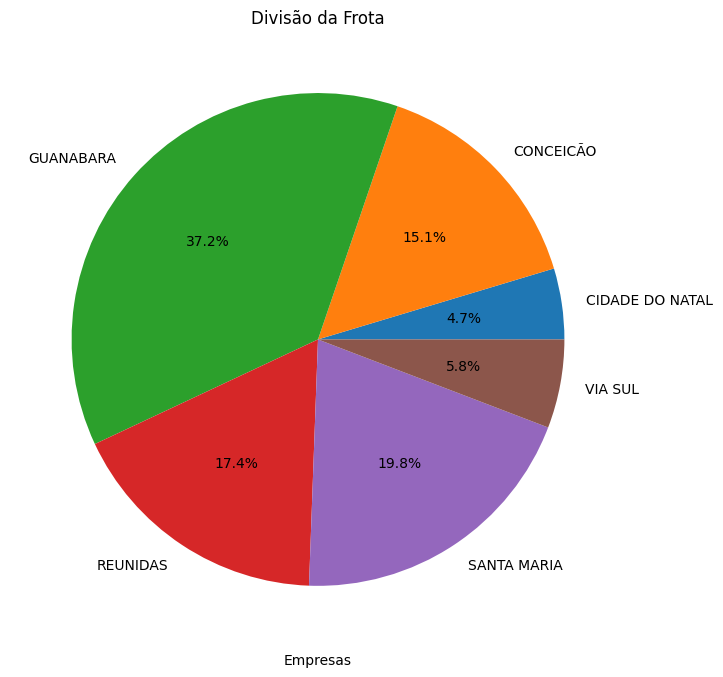

In [86]:
# Agrupe os dados por empresa e conte o número de linhas em cada grupo
contagem_linhas = analisis.groupby('Empresa').size()

# Plotar o gráfico de pizza
fig, ax = plt.subplots(figsize=(8, 8))  # Ajuste o tamanho da figura
contagem_linhas.plot(kind='pie', ax=ax, autopct='%1.1f%%')

# Personalizar o gráfico
plt.xlabel('Empresas')
plt.title('Divisão da Frota')

# Exibir o gráfico
plt.show()

In [87]:
bilhetagem = pd.read_csv('/content/drive/MyDrive/PROJETO_TRANSPORTE_URBANO/bilhetagem.csv')
bilhetagem.head()

Empresa  Linha  Media_Viagens_Anual  Media_Passagens_Anual
0  CONCEIÇÃO     21          2342.000000          119023.333333
1  CONCEIÇÃO     30          1510.750000           65669.833333
2  CONCEIÇÃO     31             1.000000               2.000000
3  CONCEIÇÃO     41            52.375000            1794.125000
4  CONCEIÇÃO     59          1711.583333           84009.333333

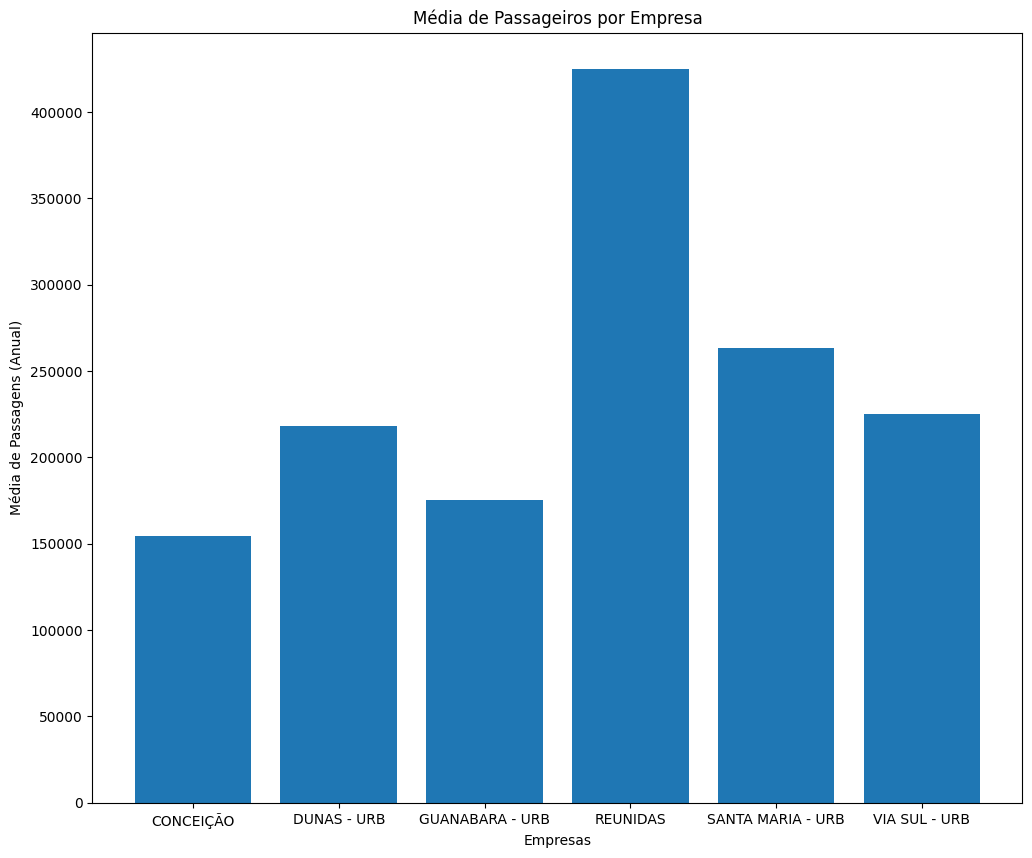

In [88]:
fig, ax = plt.subplots(figsize=(12, 10))  # Ajuste o tamanho da figura

plt.bar(bilhetagem['Empresa'], bilhetagem['Media_Passagens_Anual'])

plt.xlabel('Empresas')
plt.ylabel('Média de Passagens (Anual)')
plt.title('Média de Passageiros por Empresa')

plt.show()

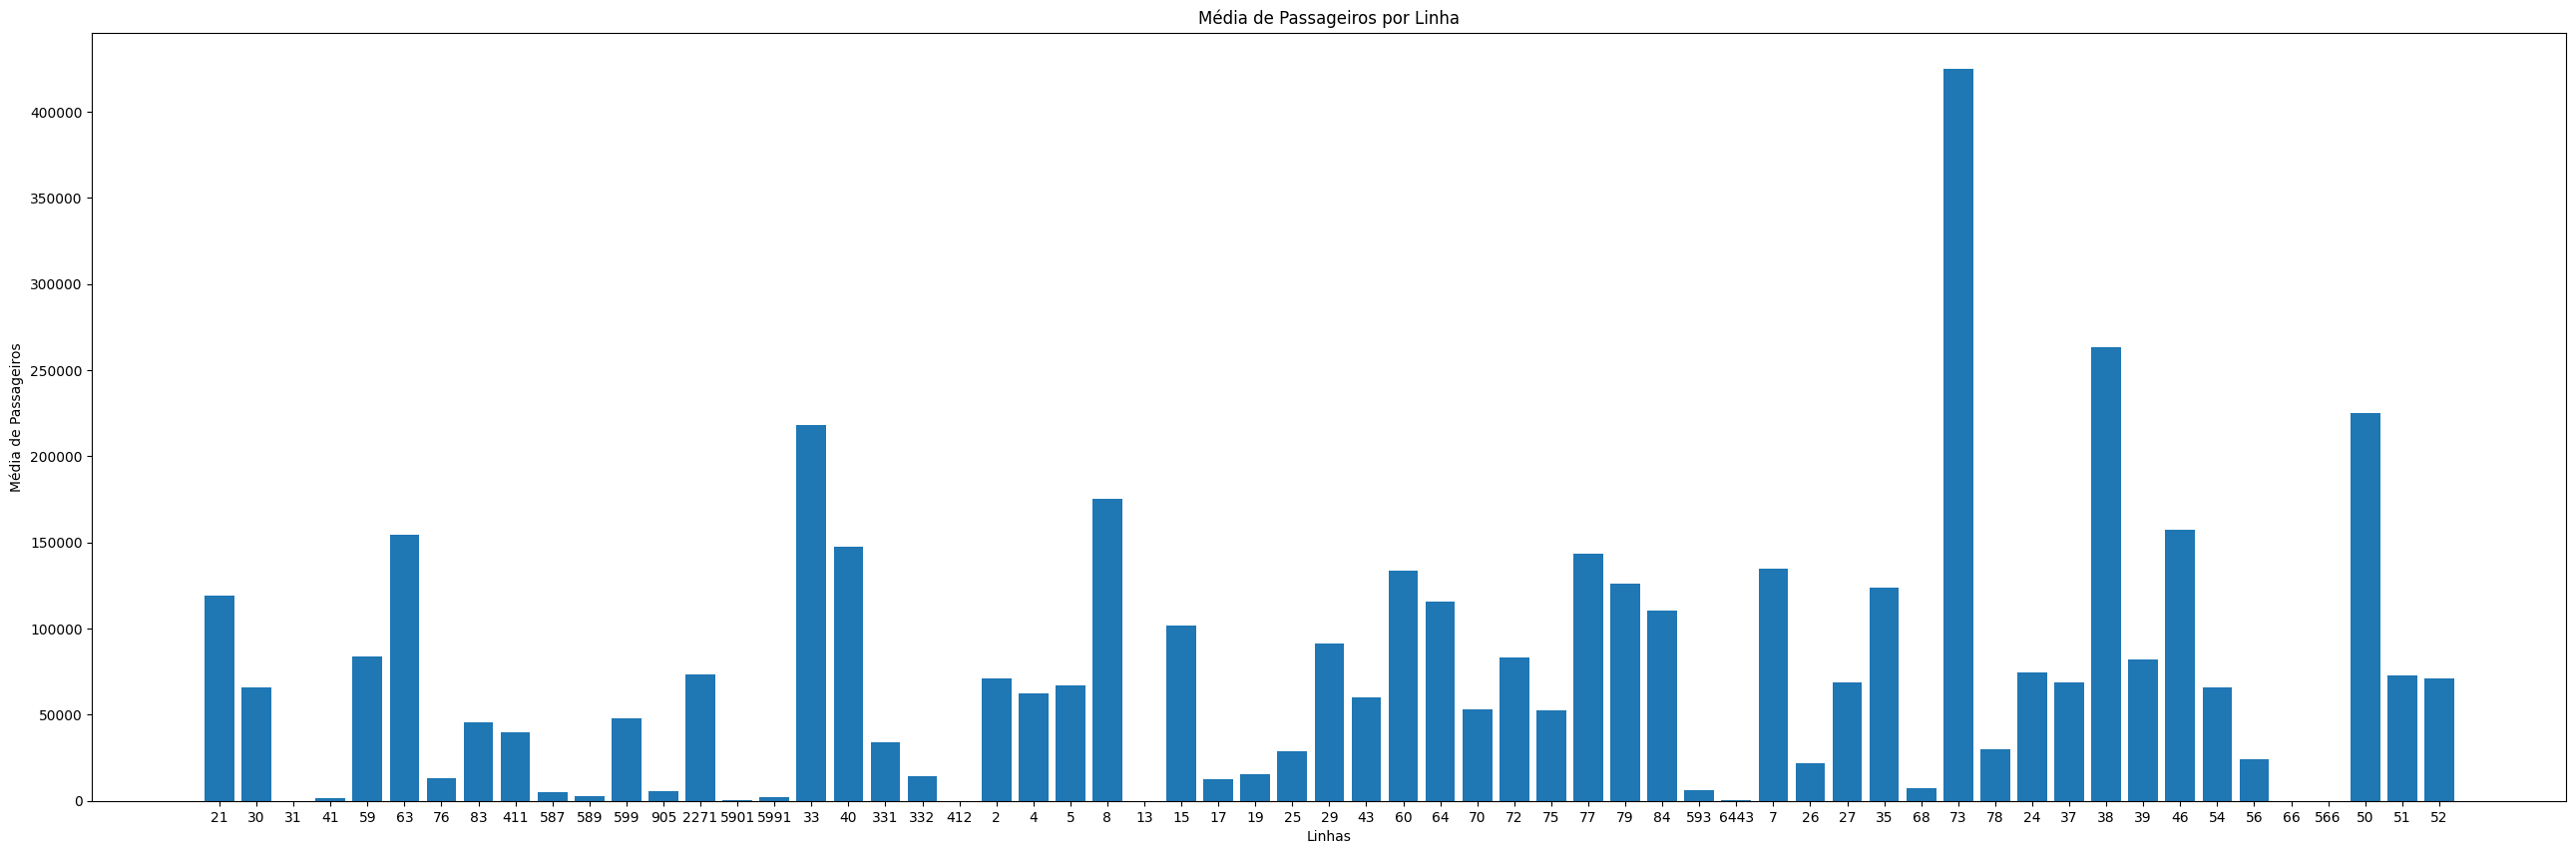

In [89]:
fig, ax = plt.subplots(figsize=(32, 10))  # Ajuste o tamanho da figura

plt.bar(bilhetagem['Linha'].astype(str), bilhetagem['Media_Passagens_Anual'])

plt.xlabel('Linhas')
plt.ylabel('Média de Passageiros')
plt.title('Média de Passageiros por Linha')

plt.show()

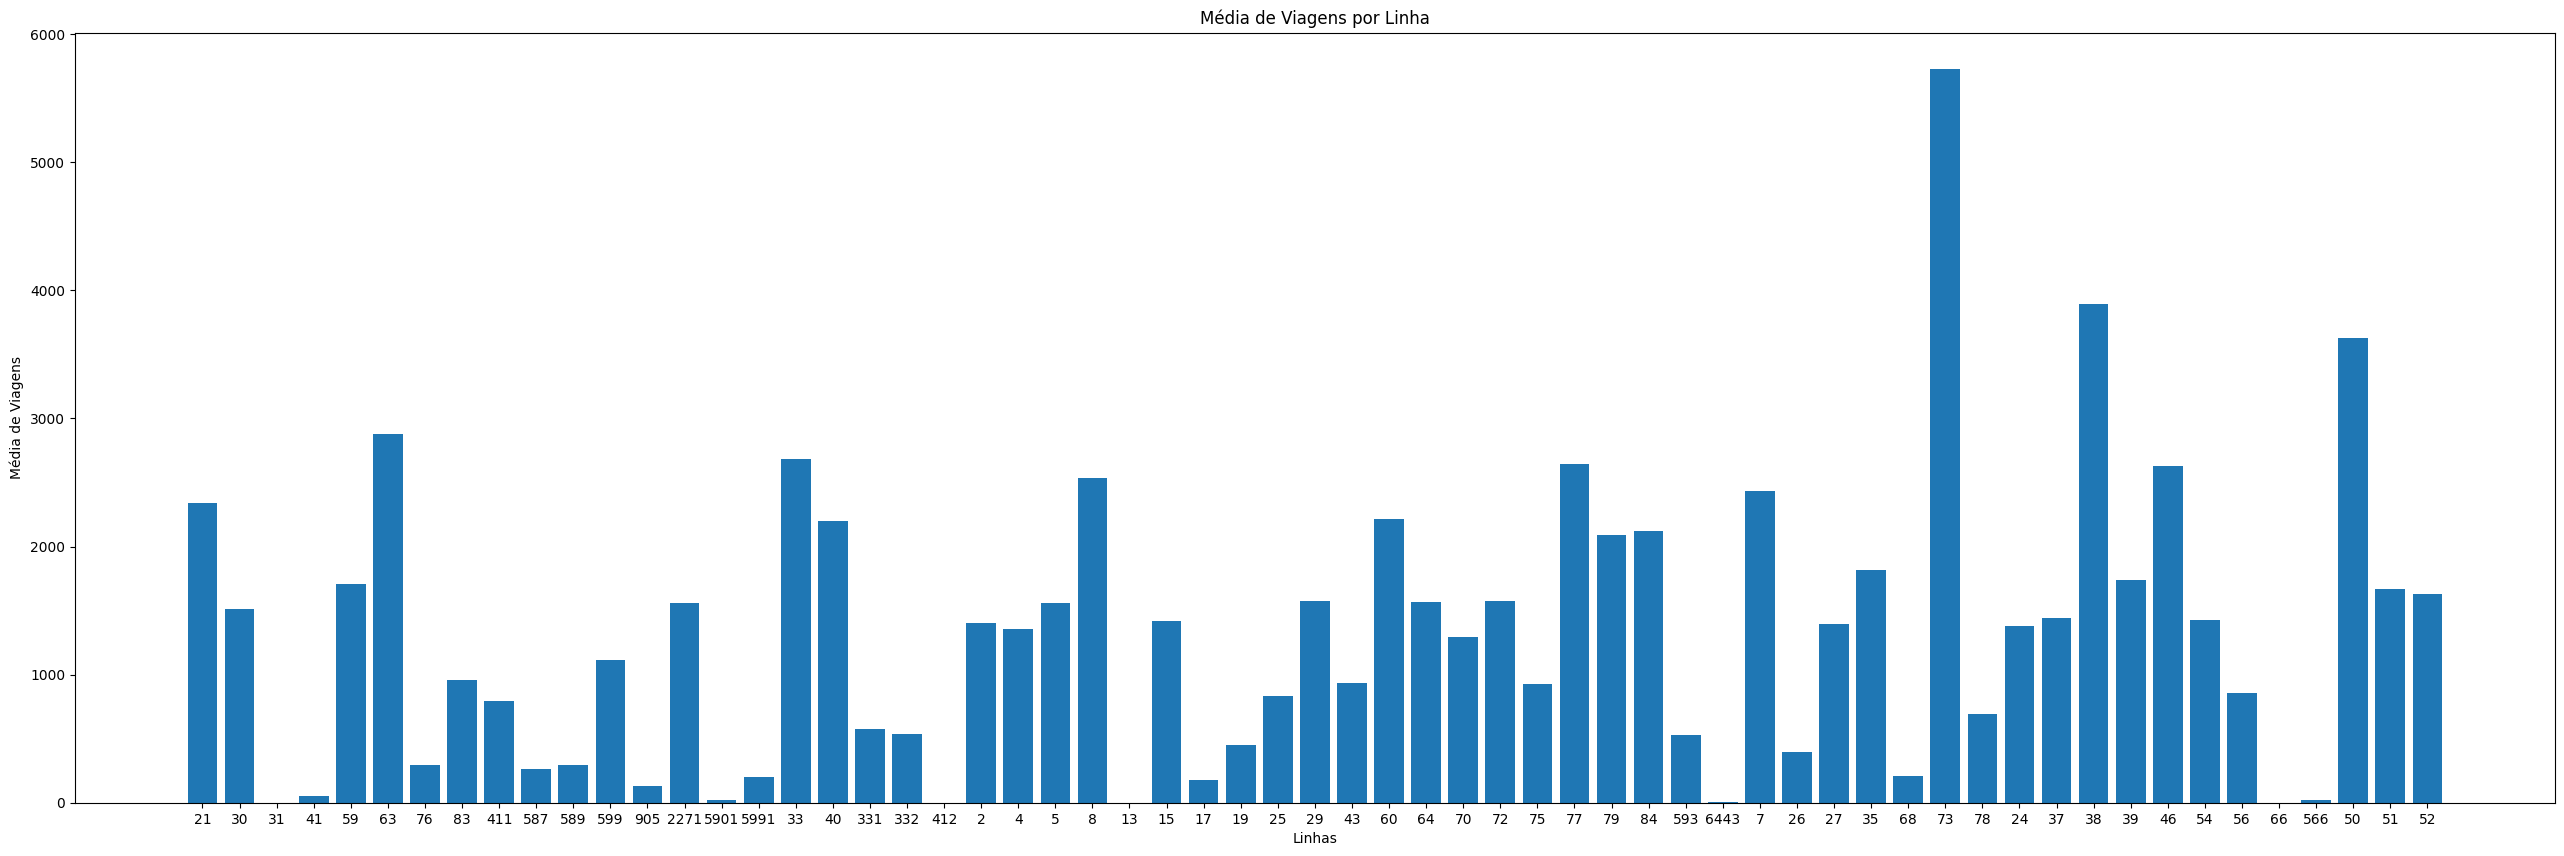

In [90]:
fig, ax = plt.subplots(figsize=(32, 10))  # Ajuste o tamanho da figura

plt.bar(bilhetagem['Linha'].astype(str), bilhetagem['Media_Viagens_Anual'])

plt.xlabel('Linhas')
plt.ylabel('Média de Viagens')
plt.title('Média de Viagens por Linha')

plt.show()

In [91]:
bilhetagem_analitico =  pd.read_csv('/content/drive/MyDrive/PROJETO_TRANSPORTE_URBANO/bilhetagem_analitico.csv', encoding='latin')

# Somar Inteira_Cartao e Inteira_Especie e adicionar como coluna "Inteira"
bilhetagem_analitico['Inteira'] = bilhetagem_analitico['Inteira_Cartao'] + bilhetagem_analitico['Inteira_Especie']

# Somar Estudante_Cartao e Estudante_BT e adicionar como coluna "Estudante"
bilhetagem_analitico['Estudante'] = bilhetagem_analitico['Estudante_Cartao'] + bilhetagem_analitico['Estudante_BT']

# Somar Gratuito_Cartao, Gratuito_BT e Tarifa_Social e adicionar como coluna "Gratuidade/Social"
bilhetagem_analitico['Gratuidade/Social'] = bilhetagem_analitico['Gratuito_Cartao'] + bilhetagem_analitico['Gratuito_BT'] + bilhetagem_analitico['Tarifa_Social']

# Somar Integracao_Plena e Integracao_Complementar e adicionar como coluna "Integracao"
bilhetagem_analitico['Integracao'] = bilhetagem_analitico['Integracao_Plena'] + bilhetagem_analitico['Integracao_Complementar']

bilhetagem_analitico = bilhetagem_analitico.drop(['Estudante_Cartao', 'Estudante_BT', 'Vale_Transporte', 'Integracao_Plena', 'Integracao_Complementar', 'Gratuito_Cartao', 'Gratuito_BT', 'Inteira_Cartao', 'Inteira_Especie', 'Tarifa_Social', 'Qtd_Viagens', 'Mes'], axis=1)
bilhetagem_analitico

Empresa  Linha  Inteira  Estudante  Gratuidade/Social  \
0            CONCEIÇÃO     21    31800       8838              15110   
1            CONCEIÇÃO     30    15554       4992               5041   
2            CONCEIÇÃO     41     2323        942               1027   
3            CONCEIÇÃO     59    21873       6972              12660   
4            CONCEIÇÃO     63    35527      13483              13782   
..                 ...    ...      ...        ...                ...   
692  SANTA MARIA - URB    332     3570       2966               1206   
693  SANTA MARIA - URB    411     8553       6106               3879   
694      VIA SUL - URB     50    67159      37015              23630   
695      VIA SUL - URB     51    19342      14495               9857   
696      VIA SUL - URB     52    22704      13813              13802   

     Integracao  
0          4197  
1          4016  
2          1128  
3          3765  
4          8368  
..          ...  
692        1212  
693        2542  
694       20291  
695        6878  
696        6554  

[697 rows x 6 columns]

In [92]:
bilhetagem_analitico = bilhetagem_analitico.groupby(['Empresa', 'Linha']).mean()
bilhetagem_analitico.head()

Inteira     Estudante  Gratuidade/Social   Integracao
Empresa   Linha                                                            
CONCEIÇÃO 21     38565.750000  20274.750000       19734.166667  5795.416667
          30     19489.166667  13123.583333        6926.416667  5895.916667
          31         0.000000      0.000000           0.000000     0.000000
          41       522.625000    259.625000         216.500000   205.500000
          59     26585.166667  14681.583333       15751.833333  4782.833333

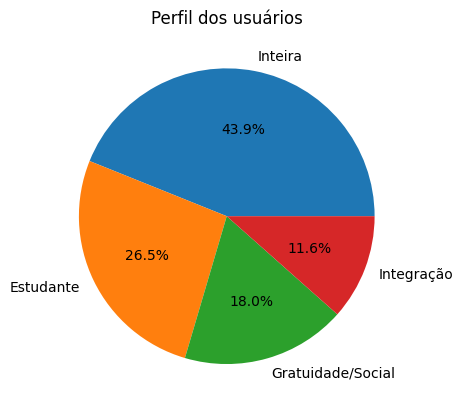

In [93]:
# Calcular as somas das colunas
soma_inteira = bilhetagem_analitico['Inteira'].sum()
soma_estudante = bilhetagem_analitico['Estudante'].sum()
soma_gratuidade_social = bilhetagem_analitico['Gratuidade/Social'].sum()
soma_integracao = bilhetagem_analitico['Integracao'].sum()

# Criar uma lista com as somas
somas = [soma_inteira, soma_estudante, soma_gratuidade_social, soma_integracao]

# Criar uma lista com os rótulos das colunas
rotulos = ['Inteira', 'Estudante', 'Gratuidade/Social', 'Integração']

# Criar o gráfico de pizza
plt.pie(somas, labels=rotulos, autopct='%1.1f%%')

# Adicionar título ao gráfico
plt.title('Perfil dos usuários')

# Exibir o gráfico
plt.show()

Podemos realizar diversas analises a partir das visualizações desses dados, o mais importante em relação ao perfil dos usuários é que podemos observar que ainda temos uma grande massa que utiliza a forma de pagamento de passagem inteira enquanto menos que 1/5 da população utiliza da gratuidade.

###Criação da visualização no Pyvis

In [94]:
!pip install pyvis

In [97]:
from pyvis.network import Network
import networkx as nx
from IPython.core.display import display, HTML

nx_graph = nx.cycle_graph(G)

nt = Network('500px', '1850px', notebook=True, cdn_resources="in_line", select_menu=True)
nt.set_options('var options = {"configure": {"enabled": true, "edges":{"color": {"inherit": true}},"filter": ["physics"]}}')
nt.from_nx(nx_graph)
nt.show('analise_mobilidade.html')

analise_mobilidade.html
